# Manuscript figures

In [17]:
import numpy as np
from partition_decode.models import ReluNetRegressor
from partition_decode.dataset import generate_gaussian_parity
import torch
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from partition_decode.df_utils import (
    get_tree_evals,
    get_forest_evals,
    get_forest_irm,
    get_tree_irm,
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
import os
from scipy.stats import spearmanr, entropy

sns.set_style('white')

## XOR data

In [18]:
X, y = generate_gaussian_parity(
    n_samples=2000, angle_params=0, random_state=1, cov_scale=1.0
)

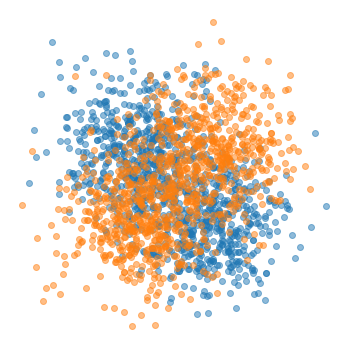

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for l in np.unique(y):
    idx = np.where(y == l)[0]
    ax.scatter(X[idx, 0], X[idx, 1], label=f'Class {l}', alpha=0.5)
plt.axis('off')
plt.tight_layout()
plt.savefig('./figures/xor_data.pdf')
plt.show()

## Forest partitions

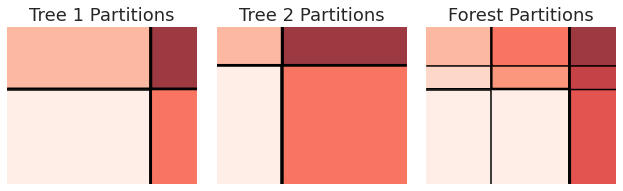

In [20]:
sns.set_context('talk')
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

X1 = np.linspace(-1, 1, 101)
X2 = np.linspace(-1, 1, 101)
XX, YY = np.meshgrid(X1, X2)

def partition_assignment1(X):
    return np.unique(
        np.vstack((
            X[:, 0] > 0.5,
            X[:, 1] > 0.2
        )).T,
        axis=0,
        return_inverse=True,
    )[1]

def partition_assignment2(X):
    return np.unique(
        np.vstack((
            X[:, 0] > -0.3,
            X[:, 1] > 0.5,
        )).T,
        axis=0,
        return_inverse=True,
    )[1]

ax = axes[0]
Z1 = partition_assignment1(np.vstack((XX.flatten(), YY.flatten())).T)
ax.contour(XX, YY, Z1.reshape(XX.shape), colors='black', linewidths=1.5, linestyles='-')
ax.contourf(XX, YY, Z1.reshape(XX.shape), alpha=0.8, cmap='Reds')
ax.set_title('Tree 1 Partitions')

ax = axes[1]
Z2 = partition_assignment2(np.vstack((XX.flatten(), YY.flatten())).T)
ax.contour(XX, YY, Z2.reshape(XX.shape), colors='black', linewidths=1.5, linestyles='-')
ax.contourf(XX, YY, Z2.reshape(XX.shape), alpha=0.8, cmap='Reds')
ax.set_title('Tree 2 Partitions')

ax = axes[2]
Z3 = np.unique(
    np.vstack((
        Z1, Z2
    )).T,
    axis=0,
    return_inverse=True,
)[1]
ax.contour(XX, YY, Z3.reshape(XX.shape), colors='black', linewidths=1.5, linestyles='-')
ax.contourf(XX, YY, Z3.reshape(XX.shape), alpha=0.8, cmap='Reds')
ax.set_title('Forest Partitions')

for ax in axes:
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.axis('off')
plt.tight_layout()
plt.savefig('./figures/forest_partitions.pdf')
plt.show()

## Network partitions

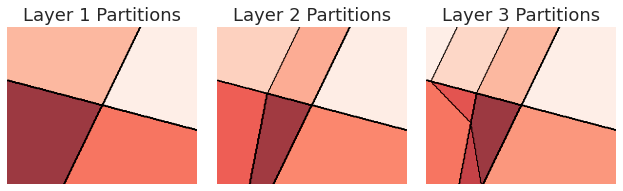

In [21]:
sns.set_context('talk')
X1 = np.linspace(-1, 1, 201)
X2 = np.linspace(-1, 1, 201)
XX, YY = np.meshgrid(X1, X2)

width = 2
depth = 3
np.random.seed(987654) # 128 129 54
# unbiased weights
weights = [np.random.normal(0, 1, (2, width))]
weights += [np.random.normal(0, 1, (width, width)) for _ in range(depth-1)]
weights = [w / np.linalg.norm(w, axis=0) for w in weights]
betas = [np.random.normal(0, 1, (width)) for _ in range(depth)]
betas = [b / np.linalg.norm(b) / 2 for b in betas]
betas[0] *= 0

def partition_assignment(X, layer=None):
    polytopes = []
    for w, b in zip(weights[:layer], betas[:layer]):
        X = X @ w + b
        X[X < 0] = 0
        polytopes.append((X > 0).astype(int))

    return np.unique(
        np.hstack(polytopes),
        axis=0,
        return_inverse=True,
    )[1]

fig, axes = plt.subplots(1, depth, figsize=(3*depth, 3))
for i in range(depth):
    ax = axes[i]
    Z1 = partition_assignment(np.vstack((XX.flatten(), YY.flatten())).T, layer=i+1)
    ax.contour(XX, YY, Z1.reshape(XX.shape), colors='black', linewidths=1, linestyles='-')
    ax.contourf(XX, YY, Z1.reshape(XX.shape), alpha=0.8, cmap='Reds')
    ax.set_title(f'Layer {i+1} Partitions')

for ax in axes:
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.axis('off')
plt.tight_layout()
plt.savefig('./figures/network_partitions.pdf')
plt.show()

## Forest XOR Double Descent

In [22]:
algo = "forest"
dataset = "xor"
# Read
df = pd.read_csv(f'./varying_model_results/{dataset}/{dataset}_{algo}_results.csv', index_col=0)
# Define headers
metric = "mse"
train_error = f'train_{metric}'
test_error = f'test_{metric}'
# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass
# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df['IRM_L1'] = df['IRM_L1'] / df['n_train_samples'] / df['n_total_leaves'] * df['n_estimators']
df['n_regions'] = df['n_regions'] / df['n_train_samples']

df_max_leaves = df[df['n_estimators'] == 1]['n_total_leaves'].max()
df['expected_leaves'] = df.apply(
    lambda row: row['n_total_leaves'] if row['n_estimators'] == 1 else row['n_estimators'] * df_max_leaves,
    axis=1
)

df = df.groupby(
    ['model', 'n_train_samples', 'max_depth', 'n_estimators'],
    as_index=False,
).mean()

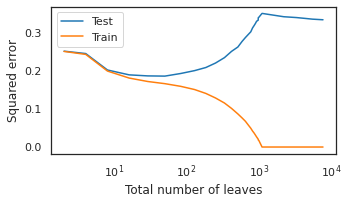

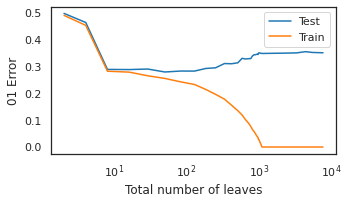

In [23]:
sns.set_context('notebook')
plot_df = df
x_var = 'expected_leaves'

for metric, ylab in [('mse', 'Squared error'), ('01_error', '01 Error')]:
    train_error = f'train_{metric}'
    test_error = f'test_{metric}'

    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)

    sns.lineplot(
        data=df, x=x_var, y=test_error,
        ax=ax, label='Test')
    sns.lineplot(
        data=df, x=x_var, y=train_error,
        ax=ax, label='Train')

    plt.xscale('log')
    plt.ylabel(ylab)
    plt.xlabel('Total number of leaves')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./figures/{algo}_{dataset}_{metric}_vs_param.pdf')
    plt.show()

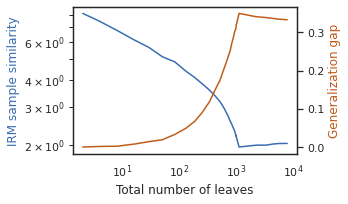

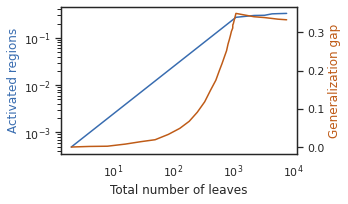

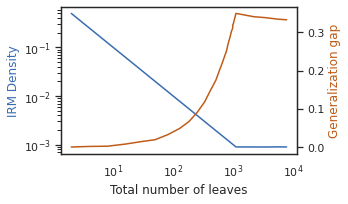

In [25]:
plot_vars = [
    ('IRM_mean_sim_entropy', 'IRM sample similarity'),
    ('n_regions', 'Activated regions'),
    ('IRM_L1', 'IRM Density'),
]
x_var = 'expected_leaves'
metric = 'mse'
train_error = f'train_{metric}'
test_error = f'test_{metric}'
df['generalization_gap'] = df[test_error] - df[train_error]

for plot_var, ylab in plot_vars:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)

    sns.lineplot(
        data=df, x=x_var, y=plot_var,
        ax=ax, color='#386cb0')
    ax.set_ylabel(ylab, color='#386cb0')
    # ax.legend()
    ax.set_yscale('log')
    
    ax2 = ax.twinx()
    sns.lineplot(
        data=df, x=x_var, y='generalization_gap',
        ax=ax2, color='#bf5b17')
    ax2.set_ylabel('Generalization gap', color='#bf5b17')
    # ax2.legend()
    # ax2.set_yscale('log')

    ax2.set_xscale('log')
    ax.set_xlabel('Total number of leaves')
    plt.tight_layout()
    plt.savefig(f'./figures/{algo}_{dataset}_{plot_var}.pdf')
    plt.show()

## Forest MNIST Double Descent

In [26]:
algo = "forest"
dataset = "mnist"
# Read
df = pd.read_csv(f'./varying_model_results/{dataset}/{dataset}_{algo}_belkin_results.csv', index_col=0)

# Define headers
metric = "mse"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass
# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df['IRM_L1'] = df['IRM_L1'] / df['n_train_samples'] / df['n_total_leaves'] * df['n_estimators']
df['n_regions'] = df['n_regions'] / df['n_train_samples']

df_max_leaves = df[df['n_estimators'] == 1]['n_total_leaves'].max()
df['expected_leaves'] = df.apply(
    lambda row: row['n_total_leaves'] if row['n_estimators'] == 1 else row['n_estimators'] * df_max_leaves,
    axis=1
)

df = df.groupby(
    ['model', 'n_train_samples', 'max_depth', 'n_estimators'],
    as_index=False,
).mean()

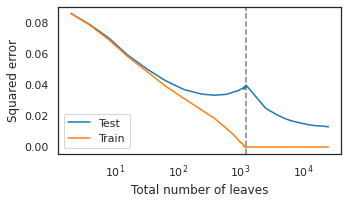

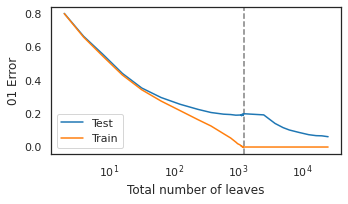

In [27]:
sns.set_context('notebook')
plot_df = df
x_var = 'expected_leaves'

for metric, ylab in [('mse', 'Squared error'), ('01_error', '01 Error')]:
    train_error = f'train_{metric}'
    test_error = f'test_{metric}'

    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
    
    ax.axvline(df[df['n_estimators'] == 1]['n_total_leaves'].max(), ls='--', c='grey')

    sns.lineplot(
        data=df, x=x_var, y=test_error,
        ax=ax, label='Test')
    sns.lineplot(
        data=df, x=x_var, y=train_error,
        ax=ax, label='Train')

    plt.xscale('log')
    plt.ylabel(ylab)
    plt.xlabel('Total number of leaves')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig(f'./figures/{algo}_{dataset}_{metric}_vs_param.pdf')
    plt.show()

In [28]:
metric = "mse"
train_error = f'train_{metric}'
test_error = f'test_{metric}'
df['generalization_gap'] = df[test_error] - df[train_error]

x_var = 'expected_leaves'
interp = df[df['n_estimators']==1]['n_total_leaves'].max()

corr_df = df[df[x_var] <= interp].corr('spearman')
series1 = corr_df['generalization_gap']

corr_df = df[df[x_var] >= interp].corr('spearman')
series2 = corr_df['generalization_gap']

corr_df = df.corr('spearman')
series3 = corr_df['generalization_gap']

corr_df = pd.concat((series1, series2, series3), axis=1)
corr_df.columns = ['First_descent', 'Second_descent', 'Overall']

print('Correlation with mse generalization gap')
display(corr_df)

Correlation with mse generalization gap


,First_descent,Second_descent,Overall
n_train_samples,NaN,NaN,NaN
n_estimators,NaN,-1.000000,-0.325058
rep,NaN,NaN,NaN
n_test_samples,NaN,NaN,NaN
onehot,NaN,NaN,NaN
bootstrap,NaN,NaN,NaN
n_jobs,NaN,NaN,NaN
train_01_error,-0.960614,0.522233,-0.422669
train_mse,-0.962065,0.522233,-0.423364
test_01_error,-0.476752,1.000000,-0.150607


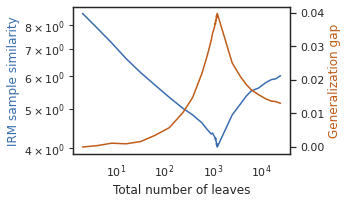

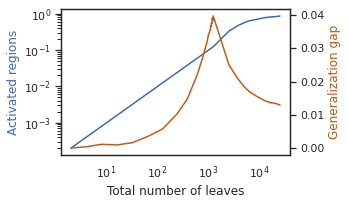

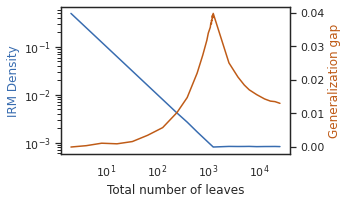

In [29]:
plot_vars = [
    ('IRM_mean_sim_entropy', 'IRM sample similarity'),
    ('n_regions', 'Activated regions'),
    ('IRM_L1', 'IRM Density'),
]
x_var = 'expected_leaves'
metric = 'mse'
train_error = f'train_{metric}'
test_error = f'test_{metric}'
df['generalization_gap'] = df[test_error] - df[train_error]

for plot_var, ylab in plot_vars:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)

    sns.lineplot(
        data=df, x=x_var, y=plot_var,
        ax=ax, color='#386cb0')
    ax.set_ylabel(ylab, color='#386cb0')
    # ax.legend()
    ax.set_yscale('log')
    
    ax2 = ax.twinx()
    sns.lineplot(
        data=df, x=x_var, y='generalization_gap',
        ax=ax2, color='#bf5b17')
    ax2.set_ylabel('Generalization gap', color='#bf5b17')
    # ax2.legend()
    # ax2.set_yscale('log')

    ax2.set_xscale('log')
    ax.set_xlabel('Total number of leaves')
    plt.tight_layout()
    plt.savefig(f'./figures/{algo}_{dataset}_{plot_var}.pdf')
    plt.show()

## NN MNIST Double Descent

In [30]:
algo = "relu_regressor"
dataset = "mnist"
# Read
df = pd.read_csv(f'./varying_model_results/{dataset}/{dataset}_{algo}_belkin_results.csv', index_col=0)
# Define headers
metric = "01_error"
train_error = f'train_{metric}'
test_error = f'test_{metric}'
# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass
# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df['IRM_L1'] = df['IRM_L1'] / df['n_train_samples']
df['n_regions'] = df['n_regions'] / df['n_train_samples']

df = df.groupby(
    ['model', 'n_train_samples', 'hidden_layer_dims', 'n_epochs'],
    as_index=False,
).mean()

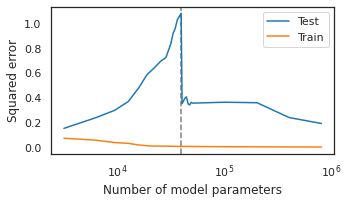

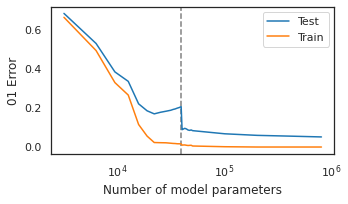

In [31]:
sns.set_context('notebook')

plot_df = df
x_var = 'n_parameters'

for metric, ylab in [('mse', 'Squared error'), ('01_error', '01 Error')]:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
    train_error = f'train_{metric}'
    test_error = f'test_{metric}'
    ax.axvline(10*df['n_train_samples'].iloc[0], ls='--', c='grey')

    sns.lineplot(
        data=df, x=x_var, y=test_error,
        ax=ax, label='Test')
    sns.lineplot(
        data=df, x=x_var, y=train_error,
        ax=ax, label='Train')

    plt.xscale('log')
    plt.ylabel(ylab)
    plt.xlabel('Number of model parameters')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./figures/{algo}_{dataset}_{metric}_vs_param.pdf')
    plt.show()

In [32]:
metric = "mse"
train_error = f'train_{metric}'
test_error = f'test_{metric}'
df['generalization_gap'] = df[test_error] - df[train_error]

x_var = 'n_parameters'
interp = 10*df['n_train_samples'].iloc[0]

corr_df = df[df[x_var] <= interp].corr('spearman')
series1 = corr_df['generalization_gap']

corr_df = df[df[x_var] >= interp].corr('spearman')
series2 = corr_df['generalization_gap']

corr_df = df.corr('spearman')
series3 = corr_df['generalization_gap']

corr_df = pd.concat((series1, series2, series3), axis=1)
corr_df.columns = ['First_descent', 'Second_descent', 'Overall']

print('Correlation with mse generalization gap')
display(corr_df)

Correlation with mse generalization gap


,First_descent,Second_descent,Overall
n_train_samples,NaN,NaN,NaN
hidden_layer_dims,1.000000,-0.496503,-0.123932
n_epochs,NaN,NaN,NaN
rep,NaN,NaN,NaN
n_test_samples,NaN,NaN,NaN
onehot,NaN,NaN,NaN
learning_rate,NaN,NaN,NaN
batch_size,NaN,NaN,NaN
verbose,NaN,NaN,NaN
early_stop_thresh,NaN,NaN,NaN


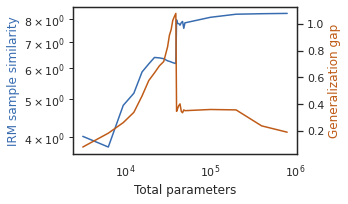

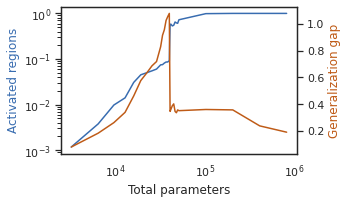

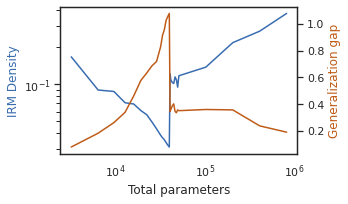

In [33]:
plot_vars = [
    ('IRM_mean_sim_entropy', 'IRM sample similarity'),
    ('n_regions', 'Activated regions'),
    ('IRM_L1', 'IRM Density'),
]
x_var = 'n_parameters'
metric = 'mse'
train_error = f'train_{metric}'
test_error = f'test_{metric}'
df['generalization_gap'] = df[test_error] - df[train_error]

for plot_var, ylab in plot_vars:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)

    sns.lineplot(
        data=df, x=x_var, y=plot_var,
        ax=ax, color='#386cb0')
    ax.set_ylabel(ylab, color='#386cb0')
    # ax.legend()
    ax.set_yscale('log')
    
    ax2 = ax.twinx()
    sns.lineplot(
        data=df, x=x_var, y='generalization_gap',
        ax=ax2, color='#bf5b17')
    ax2.set_ylabel('Generalization gap', color='#bf5b17')
    # ax2.legend()
    # ax2.set_yscale('log')

    ax2.set_xscale('log')
    ax.set_xlabel('Total parameters')
    plt.tight_layout()
    plt.savefig(f'./figures/{algo}_{dataset}_{plot_var}.pdf')
    plt.show()

## Forest MNIST Shuffle

In [34]:
algo = "forest"
dataset = "mnist"
# Read
df = pd.read_csv(f'./varying_data_results/{dataset}/{dataset}_{algo}_results.csv', index_col=0)

# Define headers
metric = "mse"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass
# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df['IRM_L1'] = df['IRM_L1'] / df['n_train_samples'] / df['n_total_leaves'] * df['n_estimators']
df['n_regions'] = df['n_regions'] / df['n_train_samples']

df_max_leaves = df[df['n_estimators'] == 1]['n_total_leaves'].max()
df['expected_leaves'] = df.apply(
    lambda row: row['n_total_leaves'] if row['n_estimators'] == 1 else row['n_estimators'] * df_max_leaves,
    axis=1
)

df = df.groupby(
    ['model', 'n_train_samples', 'max_depth', 'n_estimators', 'shuffle_label_frac'],
    as_index=False,
).mean()

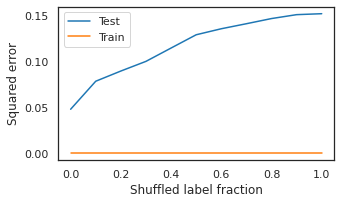

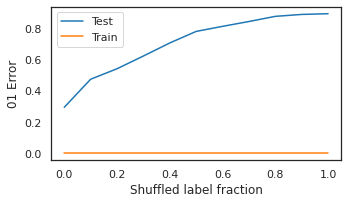

In [35]:
sns.set_context('notebook')
plot_df = df
x_var = 'shuffle_label_frac'

for metric, ylab in [('mse', 'Squared error'), ('01_error', '01 Error')]:
    train_error = f'train_{metric}'
    test_error = f'test_{metric}'

    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
    
    sns.lineplot(
        data=df, x=x_var, y=test_error,
        ax=ax, label='Test')
    sns.lineplot(
        data=df, x=x_var, y=train_error,
        ax=ax, label='Train')

    # plt.xscale('log')
    plt.ylabel(ylab)
    plt.xlabel('Shuffled label fraction')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./figures/{algo}_{dataset}_{metric}_vs_label_shuffle.pdf')
    plt.show()

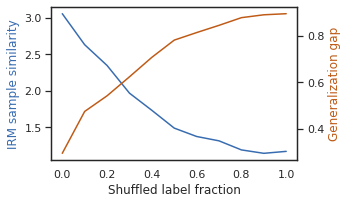

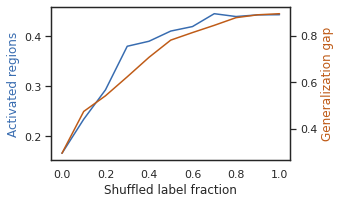

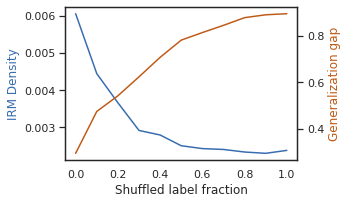

In [36]:
plot_vars = [
    ('IRM_mean_sim_entropy', 'IRM sample similarity'),
    ('n_regions', 'Activated regions'),
    ('IRM_L1', 'IRM Density'),
]
x_var = 'shuffle_label_frac'
metric = '01_error'
train_error = f'train_{metric}'
test_error = f'test_{metric}'
df['generalization_gap'] = df[test_error] - df[train_error]

for plot_var, ylab in plot_vars:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)

    sns.lineplot(
        data=df, x=x_var, y=plot_var,
        ax=ax, color='#386cb0')
    ax.set_ylabel(ylab, color='#386cb0')
    # ax.legend()
    # ax.set_yscale('log')
    
    ax2 = ax.twinx()
    sns.lineplot(
        data=df, x=x_var, y='generalization_gap',
        ax=ax2, color='#bf5b17')
    ax2.set_ylabel('Generalization gap', color='#bf5b17')
    # ax2.legend()
    # ax2.set_yscale('log')

    # ax2.set_xscale('log')
    ax.set_xlabel('Shuffled label fraction')
    plt.tight_layout()
    plt.savefig(f'./figures/{algo}_{dataset}_{plot_var}_shuffled_labels.pdf')
    plt.show()

## NN MNIST Shuffle

In [37]:
algo = "relu_regressor"
dataset = "mnist"
# Read
df = pd.read_csv(f'./varying_data_results/{dataset}/{dataset}_{algo}_results.csv', index_col=0)
# Define headers
metric = "01_error"
train_error = f'train_{metric}'
test_error = f'test_{metric}'
# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass
# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df['IRM_L1'] = df['IRM_L1'] / df['n_train_samples']
df['n_regions'] = df['n_regions'] / df['n_train_samples']

df = df.groupby(
    ['model', 'n_train_samples', 'hidden_layer_dims', 'n_epochs', 'shuffle_label_frac'],
    as_index=False,
).mean()

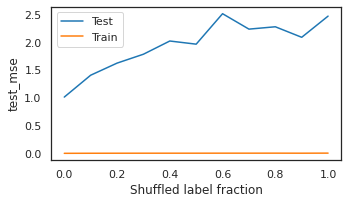

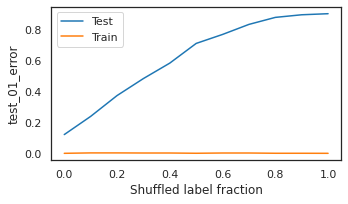

In [38]:
sns.set_context('notebook')
plot_df = df
x_var = 'shuffle_label_frac'

for metric, ylab in [('mse', 'Squared error'), ('01_error', '01 Error')]:
    train_error = f'train_{metric}'
    test_error = f'test_{metric}'

    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)
    
    sns.lineplot(
        data=df, x=x_var, y=test_error,
        ax=ax, label='Test')
    sns.lineplot(
        data=df, x=x_var, y=train_error,
        ax=ax, label='Train')

    # plt.yscale('log')
    # plt.ylabel(ylab)
    plt.xlabel('Shuffled label fraction')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./figures/{algo}_{dataset}_{metric}_vs_label_shuffle.pdf')
    plt.show()

In [39]:
metric = "01_error"
train_error = f'train_{metric}'
test_error = f'test_{metric}'
df['generalization_gap'] = df[test_error] - df[train_error]

x_var = 'n_parameters'

corr_df = df.corr('spearman')

print('Correlation with mse generalization gap')
display(corr_df['generalization_gap'])

Correlation with mse generalization gap


n_train_samples              NaN
hidden_layer_dims            NaN
n_epochs                     NaN
shuffle_label_frac      1.000000
rep                          NaN
n_test_samples               NaN
onehot                       NaN
learning_rate                NaN
batch_size                   NaN
verbose                      NaN
early_stop_thresh            NaN
bias                         NaN
init_prior_model             NaN
train_01_error         -0.429551
train_mse               0.900000
test_01_error           1.000000
test_mse                0.872727
IRM_L0                 -0.500000
IRM_L1                  0.090909
IRM_L2                 -0.009091
n_regions                    NaN
ACTS_L2                      NaN
IRM_h*                       NaN
ACTS_h*                      NaN
IRM_entropy             0.263636
IRM_rows_mean_L2       -0.081818
IRM_cols_mean_L1        0.090909
IRM_cols_mean_L2        0.090909
IRM_mean_dot_product   -0.027273
IRM_mean_sim_entropy    0.127273
n_paramete

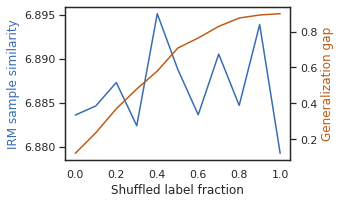

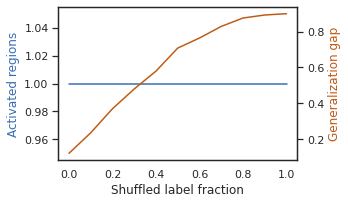

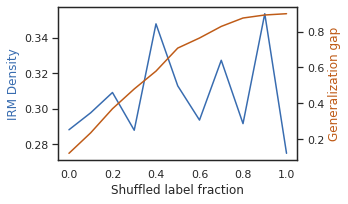

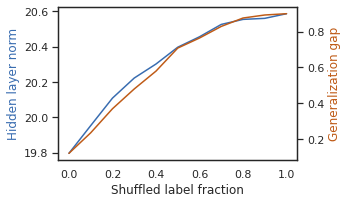

In [40]:
plot_vars = [
    ('IRM_mean_sim_entropy', 'IRM sample similarity'),
    ('n_regions', 'Activated regions'),
    ('IRM_L1', 'IRM Density'),
    ('weights_L2', 'Hidden layer norm')
]
x_var = 'shuffle_label_frac'
metric = '01_error'
train_error = f'train_{metric}'
test_error = f'test_{metric}'
df['generalization_gap'] = df[test_error] - df[train_error]

for plot_var, ylab in plot_vars:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharex=True)

    sns.lineplot(
        data=df, x=x_var, y=plot_var,
        ax=ax, color='#386cb0')
    ax.set_ylabel(ylab, color='#386cb0')
    # ax.set_yscale('log')
    
    ax2 = ax.twinx()
    sns.lineplot(
        data=df, x=x_var, y='generalization_gap',
        ax=ax2, color='#bf5b17')
    ax2.set_ylabel('Generalization gap', color='#bf5b17')

    ax.set_xlabel('Shuffled label fraction')
    plt.tight_layout()
    plt.savefig(f'./figures/{algo}_{dataset}_{plot_var}_shuffled_labels.pdf')
    plt.show()